# Import Libraries

In [68]:
from functools import partial
import os
import tempfile
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import datetime


from sklearn.impute import SimpleImputer
from torch.utils.data import Dataset, DataLoader

from ray import tune
from ray import train
from ray.train import Checkpoint, get_checkpoint
from ray.tune.schedulers import ASHAScheduler
import ray.cloudpickle as pickle

# Import Data from .csv

In [69]:
# specify year interval
# start_year = 2019
# end_year = 2022 # inclusive

# df_list = []
# for year in range(start_year, end_year + 1):
#     df = pd.read_csv(f'../data/Prepared data/{str(year)}_features.csv')
#     df_list.append(df)
# del df
# df_raw = pd.concat(df_list, axis=0, ignore_index=True)
# df = df_raw[['timestamp', 'load', 'temp', 'year', 'month', 'day', 'hour', 'minute']]

# Utilities for Preprocessing

In [70]:
import datetime
import holidays

def is_workday(date:datetime.date):
    """
    Determines the type of day (workday or not) for a given date.

    Args:
        date (datetime.date): The date to check.

    Returns:
        int: 1 if workday else 0.
    """
    us_holidays = holidays.US()

    if date in us_holidays:
        return 0

    if date.weekday() >= 5:  # Saturday is 5, Sunday is 6
        return 0

    return 1


In [71]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import torch.utils
import torch.utils.data

class TimestampTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()

        X['timestamp'] = pd.to_datetime(X['timestamp'])
        X['is_workday'] = X['timestamp'].apply(is_workday)
        return X
    
class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_len, pred_len):
        """
        Custom Dataset for multivariate time series.

        Args:
            df (pd.Dataframe): Assume the dataframe has been preprocessed and has only numeriacal values.
            seq_length (int): Length of each sequence.
            transform: Composition of transformations.
        """
        super(TimeSeriesDataset, self).__init__()
        self.df = df.reset_index(drop=True)
        self.features = self.df.values
        self.targets = self.df['load'].values
        self.seq_len = seq_len
        self.pred_len = pred_len
        
    def __len__(self):
        return len(self.features) - self.seq_len - self.pred_len + 1
    
    def __getitem__(self, idx):
        sequence = self.features[idx:idx + self.seq_len, :]
        sequence = torch.tensor(sequence, dtype=torch.float32)
        
        target = self.targets[idx + self.seq_len: idx + self.seq_len + self.pred_len]
        target = torch.tensor(target, dtype=torch.float32)
        
        return sequence, target

class Preprocessor():
    def __init__(self):
        self.timestamp_transformer = TimestampTransformer()
        self.imputer_load = SimpleImputer(strategy='mean')
        self.imputer_temp = SimpleImputer(strategy='mean')

        self.min_year = None
        
        self.load_mean = None
        self.load_std  = None
        self.temp_mean = None
        self.temp_std  = None
        self.feature_cols = ['load', 'temp', 'is_workday', 'year', 'month', 'day', 'hour', 'minute']

    def fit(self, df):

        self.imputer_load.fit(df[['load']])
        self.imputer_temp.fit(df[['temp']])

        self.min_year = df['year'].min()

        self.load_mean = df['load'].mean()
        self.load_std  = df['load'].std()
        self.temp_mean = df['temp'].mean()
        self.temp_std  = df['temp'].std()

    def transform(self, df):

        df = self.timestamp_transformer.transform(df)

        df['load'] = self.imputer_load.transform(df[['load']])
        df['temp'] = self.imputer_temp.transform(df[['temp']])

        df['year'] = df['year'] - self.min_year

        df['load'] = (df['load'] - self.load_mean) / self.load_std
        df['temp'] = (df['temp'] - self.temp_mean) / self.temp_std

        return df
    
    def inverse_transform(self, df):
        
        df['load'] = df['load'] * self.load_std + self.load_mean

        return df

    def fit_transform(self, df):
        self.fit(df)
        df_out = self.transform(df)
        return df_out

def create_dataset_splits(df_all, preprocessor, start_year, end_year, input_seq_len, output_seq_len, batch_size):
    """
    Specify the year range `start_year` and `end_year` (inclusive) for training and validation data. The end year will be used as the validation data.
    """
    df_all = df_all.sort_values('timestamp').reset_index(drop=True)

    df_all = preprocessor.fit_transform(df_all)
    print(preprocessor.load_mean, preprocessor.load_std, preprocessor.temp_mean, preprocessor.temp_std)

    if start_year + 1 == end_year:
        df_train = df_all[df_all['timestamp'].dt.year == start_year].copy().reset_index(drop=True)
    elif start_year + 1 < end_year:
        df_train = df_all[(df_all['timestamp'].dt.year >= start_year) & (df_all['timestamp'].dt.year <= end_year-1)].copy().reset_index(drop=True)
    else:
        raise ValueError('Invalid year range.')
    df_val = df_all[df_all['timestamp'].dt.year == end_year].copy().reset_index(drop=True)

    df_train = df_train.drop('timestamp', axis=1)
    df_val = df_val.drop('timestamp', axis=1)

    train_dataset = TimeSeriesDataset(df_train, input_seq_len, output_seq_len)
    val_dataset  = TimeSeriesDataset(df_val, input_seq_len, output_seq_len)

    # For Windows users, set num_workers=0; For Linux users, set num_workers=num_CPU_cores
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True, pin_memory_device='cuda')
    val_loader  = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, pin_memory_device='cuda')

    return train_loader, val_loader

# Model Implementation

In [72]:
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn

class SimpleRNN(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(num_features, hidden_size, num_layers, batch_first=True, dropout=drop_rate, nonlinearity='relu')

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)

        return out

class SimpleLSTM(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(num_features, hidden_size, num_layers, dropout=drop_rate, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
    
    # def _initialize_weights(self, num_features):
    #     # According to the paper, https://arxiv.org/pdf/1912.10454
    #     #   we want to preserve the variance through layers.
    #     # As a simplified approach:
    #     # - Set all biases to zero
    #     # - Initialize input-to-hidden weights with a variance ~ 1/N, where N is the number of features
    #     # - Initialize hidden-to-hidden weights orthogonally or with a small variance
        
    #     for name, param in self.lstm.named_parameters():
    #         if 'bias' in name:
    #             nn.init.zeros_(param)
    #         elif 'weight_ih' in name:
    #             # Input to hidden weights: normal with std ~ 1/sqrt(num_features)
    #             nn.init.normal_(param, mean=0.0, std=(1.0 / np.sqrt(num_features)))
    #         elif 'weight_hh' in name:
    #             # Hidden to hidden weights: orthogonal initialization can help stability
    #             nn.init.orthogonal_(param)

    #     # For the fully connected layer
    #     nn.init.zeros_(self.fc.bias)
    #     # Xavier is a reasonable choice for the final layer
    #     nn.init.xavier_normal_(self.fc.weight)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

class SimpleGRU(nn.Module):
    def __init__(self, num_features, output_size, hidden_size, num_layers, drop_rate=0):
        super(SimpleGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(num_features, hidden_size, num_layers, dropout=drop_rate, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out

# Training (Original Method)

In [73]:
from torch.amp import GradScaler, autocast
scaler = GradScaler()

In [74]:
import matplotlib.pyplot as plt

def evaluate_metrics(real_values, predictions): 
    ''' 
    Calculate evaluation metrics: MAE, MAPE, and R-squared. 

    Parameters 
    ---------- 

    real_values (array-like): The actual values. 
    predictions (array-like): The predicted values. 

    Returns 
    ------- 
    mae, mape, r_squared
    ''' 

    real_values = np.array(real_values) 
    predictions = np.array(predictions) 

    # Mean Absolute Error (MAE) 
    mae = np.mean(np.abs(real_values - predictions)) 

    # Mean Absolute Percentage Error (MAPE) 
    epsilon = 1e-6
    mape = np.mean(np.abs((real_values - predictions) / (real_values + epsilon))) * 100

    # R-squared 
    ss_res = np.sum((real_values - predictions) ** 2) 
    ss_tot = np.sum((real_values - np.mean(real_values)) ** 2) 
    r_squared = 1 - (ss_res / ss_tot)

    return mae, mape, r_squared

def model_evaluation(model, criterion, data_loader, device='cpu'):

    batch_losses = []

    model.eval() # switch to evalution mode
    with torch.no_grad():
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            loss = criterion(outputs, labels)
            batch_losses.append(loss.item())

    model.train() # switch to training mode

    loss_mean = np.mean(batch_losses)

    return loss_mean

def training_loop(n_epochs, optimizer, model, criterion, train_loader, test_loader, verbose=False, scheduler=None, device='cpu', save_model=None, save_as='model.pt'):
    '''
    Set `verbose=True` to see scores for each epoch. If cuda is available, set `device='cuda'`.

    Return
    ------
    - train_losses (list): history of training loss
    - test_losses (list): history of test/validation loss
    '''
    train_losses = []
    test_losses = []

    min_test_loss = float('inf')
    for n in range(n_epochs):
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad(set_to_none=True)
            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        if scheduler != None:
            scheduler.step() # update learning rate
        
        train_loss = model_evaluation(model, criterion, train_loader, device=device)
        test_loss = model_evaluation(model, criterion, test_loader, device=device)

        # save model with lowest test/validation loss
        if test_loss < min_test_loss:
            min_test_loss = test_loss
            if save_model == 'best':
                torch.save(model.state_dict(), save_as)

        # save model at last epoch
        if save_model == 'last' and n == n_epochs - 1:
            torch.save(model.state_dict(), save_as)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if ((n + 1) % 10 == 0) or verbose:
            print(f'Epoch {n + 1}/{n_epochs}: Training loss {train_loss:.4f}, Validation Loss {test_loss:.4f}')
            if scheduler != None:
                print(f"Current learning rate is {scheduler.get_last_lr()[0]}")
            print('----------------------------------------------------------')

    return train_losses, test_losses

def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    epochs = np.arange(len(train_metrics))

    plt.plot(epochs, train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(epochs, test_metrics, label=f'Test {metric_name}', color='red')

    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Traning with Ray Tune

In [75]:
# initialize preprocessor for normalization on validation data later on
preprocessor = Preprocessor()

# specify year range
start_year = 2019 # start_year to (end_year - 1) will be used for training
end_year = 2022 # will be used for validation

def train_model(config):
    batch_size = config["batch_size"]
    hidden_size = config["hidden_size"]
    num_layers = config["num_layers"]
    drop_rate = config["drop_rate"]
    lr_rate = config["lr_rate"]
    weight_decay = config["weight_decay"]
    model_type = config["model_type"]

    if model_type == 'LSTM':
        model = SimpleLSTM(num_features=8, output_size=288, hidden_size=hidden_size, num_layers=num_layers, drop_rate=drop_rate)
    elif model_type == 'GRU':
        model = SimpleGRU(num_features=8, output_size=288, hidden_size=hidden_size, num_layers=num_layers, drop_rate=drop_rate)

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    criterion = nn.HuberLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_rate, weight_decay=weight_decay, fused=True)

    checkpoint = get_checkpoint()
    if checkpoint:
        with checkpoint.as_directory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "rb") as fp:
                checkpoint_state = pickle.load(fp)
            start_epoch = checkpoint_state["epoch"]
            model.load_state_dict(checkpoint_state["net_state_dict"])
            optimizer.load_state_dict(checkpoint_state["optimizer_state_dict"])
    else:
        start_epoch = 0

    # import data from csv files
    df_list = []
    for year in range(start_year, end_year + 1):
        df = pd.read_csv(f'/home/zitong/Projects/NY-electricity-load-prediction/data/Prepared data/{str(year)}_features.csv')
        df_list.append(df)
    del df
    df_raw = pd.concat(df_list, axis=0, ignore_index=True)
    df = df_raw[['timestamp', 'load', 'temp', 'year', 'month', 'day', 'hour', 'minute']].copy()
    del df_raw, df_list

    # create train and validation data loaders
    train_loader, val_loader = create_dataset_splits(df, preprocessor=preprocessor, start_year=start_year, end_year=end_year, input_seq_len=288, output_seq_len=288, batch_size=batch_size)

    scheduler = None

    for epoch in range(start_epoch, 1):
        model.train()
        for x_batch, y_batch in train_loader:

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad(set_to_none=True)
            with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=(device=='cuda')):
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        if scheduler is not None:
            scheduler.step()

        # Train/Validation losses
        train_loss = model_evaluation(model, criterion, train_loader, device=device)
        val_loss = model_evaluation(model, criterion, val_loader, device=device)

        checkpoint_data = {
            "epoch": epoch,
            "net_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        with tempfile.TemporaryDirectory() as checkpoint_dir:
            data_path = Path(checkpoint_dir) / "data.pkl"
            with open(data_path, "wb") as fp:
                pickle.dump(checkpoint_data, fp)

            checkpoint = Checkpoint.from_directory(checkpoint_dir)
            train.report(
                {"train_loss": train_loss, "val_loss": val_loss},
                checkpoint=checkpoint,
            )

    print("Finished Training")

In [76]:
config = {
    "batch_size": tune.choice([32, 64, 128, 256]),
    "hidden_size": tune.choice([16, 32, 64, 128]),
    "num_layers": tune.choice([2, 3, 4, 5]),
    "drop_rate": tune.uniform(0.0, 0.5),
    "lr_rate": tune.loguniform(1e-5, 1e-3),
    "weight_decay": tune.loguniform(1e-6, 1e-3),
    "model_type": tune.choice(["LSTM", "GRU"]),
    "num_gpus": 1
}

scheduler = ASHAScheduler(
        metric="val_loss",
        mode="min",
        max_t=30,
        grace_period=10,
        reduction_factor=2,
)
result = tune.run(
    partial(train_model),
    resources_per_trial={"cpu": 8, "gpu": 1},
    config=config,
    num_samples=1,
    scheduler=scheduler,
)

best_trial = result.get_best_trial("val_loss", "min", "last")
print(f"Best trial config: {best_trial.config}")
print(f"Best trial final validation loss: {best_trial.last_result['val_loss']}")

2024-12-20 17:37:56,037	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,should_checkpoint,train_loss,val_loss
train_model_0e8b0_00000,True,0.23913,0.241739


2024-12-20 17:38:56,241	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/zitong/ray_results/train_model_2024-12-20_17-37-56' in 0.0020s.
2024-12-20 17:38:56,244	INFO tune.py:1041 -- Total run time: 60.21 seconds (60.18 seconds for the tuning loop).


Best trial config: {'batch_size': 64, 'hidden_size': 32, 'num_layers': 5, 'drop_rate': 0.19641044060214236, 'lr_rate': 6.697474028828594e-05, 'weight_decay': 3.868203824958299e-05, 'model_type': 'LSTM', 'num_gpus': 1}
Best trial final validation loss: 0.24173880234759834


# Make Predictions Function

In [77]:
import torch
import numpy as np

def make_predictions(model, test_data, device='cuda'):
    """
    Evaluate the model on test_data for the year 2020 and produce 1D arrays of predictions and actuals.

    Parameters
    ----------
    model : torch.nn.Module
        The trained model that takes an input of shape [1, 288, 7] and outputs [1, 288].
    test_data : torch.Tensor
        A tensor of shape [N, 7] containing continuous test data.
        The columns are [load, temp, is_workday, year, month, day, hour].
        Assume test_data is normalized/processed the same way as the training data.
    device : str, optional
        Device to run computations on ('cuda' or 'cpu'), by default 'cuda'.

    Returns
    -------
    predictions : np.ndarray
        1D array containing the model's predicted load values for all predicted timesteps.
    actuals : np.ndarray
        1D array containing the actual load values for the corresponding timesteps.
    """

    model = model.to(device)
    model.eval()

    total_steps = test_data.shape[0]
    # Each prediction uses 288 steps as input and predicts the next 288 steps.
    # Need at least 288 steps beyond the input window for a full prediction.
    max_start = total_steps - 288 * 2
    if max_start < 0:
        raise ValueError("Not enough test data to form a single input-output pair.")

    all_predictions = []
    all_actuals = []

    with torch.no_grad():
        # Slide over test_data in increments of 288 steps (e.g., one day at a time, if 288 steps = one day)
        for start_idx in range(0, max_start + 1, 288):
            # Extract input sequence
            input_seq = test_data[start_idx : start_idx+288]  # [288, 7]
            input_seq = input_seq.unsqueeze(0).to(device)     # [1, 288, 7]

            # Run the model
            pred = model(input_seq)         # [1, 288]
            pred = pred.squeeze(0).cpu().numpy()  # [288]

            # Actual load for the next 288 steps
            target_seq = test_data[start_idx+288 : start_idx+576, 0].cpu().numpy()  # [288]

            # Collect results
            all_predictions.append(pred)
            all_actuals.append(target_seq)

    # Convert to arrays of shape [M, 288]
    all_predictions = np.array(all_predictions)  # [M, 288]
    all_actuals = np.array(all_actuals)          # [M, 288]

    # Flatten to 1D arrays
    predictions = all_predictions.flatten()  # 1D array
    actuals = all_actuals.flatten()          # 1D array

    return predictions, actuals


# Load Best Model and Test on Validation Dataset

## Load Best Model

In [78]:
# Load saved models

# lstm_model = SimpleLSTM(num_features, output_size, hidden_size, num_layers).to('cuda')
# lstm_model.load_state_dict(torch.load('LSTM.pt', weights_only=True))
# lstm_model.eval()

# gru_model = SimpleGRU(num_features, output_size, hidden_size, num_layers).to('cuda')
# gru_model.load_state_dict(torch.load('GRU.pt', weights_only=True))
# gru_model.eval()

# load best model
best_trained_model = SimpleGRU(8, 288, 32, 3).to('cuda')
# best_checkpoint = result.get_best_checkpoint(trial=best_trial, metric="val_loss", mode="min")
# with best_checkpoint.as_directory() as checkpoint_dir:
        # data_path = Path(checkpoint_dir) / "data.pkl"
data_path = "best_model.pkl"
with open(data_path, "rb") as fp:
    best_checkpoint_data = pickle.load(fp)
best_trained_model.load_state_dict(best_checkpoint_data["net_state_dict"])

<All keys matched successfully>

## Test on validation dataset

In [79]:
year = 2022
df_val_raw = pd.read_csv(f'../data/Prepared data/{year}_features.csv')
df_val = df_val_raw[['timestamp', 'load', 'temp', 'year', 'month', 'day', 'hour', 'minute']].copy()
print(preprocessor.load_mean, preprocessor.load_std, preprocessor.temp_mean, preprocessor.temp_std)
preprocessing = Preprocessor()
preprocessing.fit(df_val)
preprocessing.min_year = preprocessing.min_year
preprocessing.load_mean = preprocessor.load_mean
preprocessing.load_std = preprocessor.load_std
preprocessing.temp_mean = preprocessor.temp_mean
preprocessing.temp_std = preprocessor.temp_std
df_val = preprocessing.transform(df_val)

None None None None


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [ ]:
# NYISO forecast
df_nyiso = pd.read_csv(f'../data/NYISO forcast/capital_forecast_{year}.csv')
df_nyiso['timestamp'] = pd.to_datetime(df_nyiso['timestamp'])
# df_nyiso['forcast'] = (df_nyiso['forcast'] - preprocessing.load_mean) / preprocessing.load_std
nyiso_forecast = df_nyiso['forcast'].to_numpy(dtype=np.float32)

with_forecast = pd.merge(df_nyiso, df_val, on='timestamp')
with_forecast['load'] = with_forecast['load'] * preprocessing.load_std + preprocessing.load_mean

df_val = df_val.drop('timestamp', axis=1)

# initial_np = df.iloc[:288].to_numpy(dtype=np.float32)
# initial_tensor = torch.tensor(initial_np, dtype=torch.float32)
test_np = df_val.to_numpy(dtype=np.float32)
# np.save('test_data.npy', test_np)
test_tensor = torch.tensor(test_np, dtype=torch.float32)

# predictions_rnn, actual = make_predictions(rnn_model, test_tensor, device='cuda')
# predictions_lstm, actual = make_predictions(lstm_model, test_tensor, device='cuda')
# predictions_gru, _ = make_predictions(gru_model, test_tensor, device='cuda')
predictions, actual = make_predictions(best_trained_model, test_tensor, device='cuda')

# denomralize
actual = actual * preprocessing.load_std + preprocessing.load_mean
predictions = predictions * preprocessing.load_std + preprocessing.load_mean

2022 Prediction: MAE 75.62217712402344, MAPE 5.651067942380905, R^2 0.8274927586317062
NYISO Forecast: MAE 55.079074731796396, MAPE 4.045701292213478, R^2 0.918551712856581


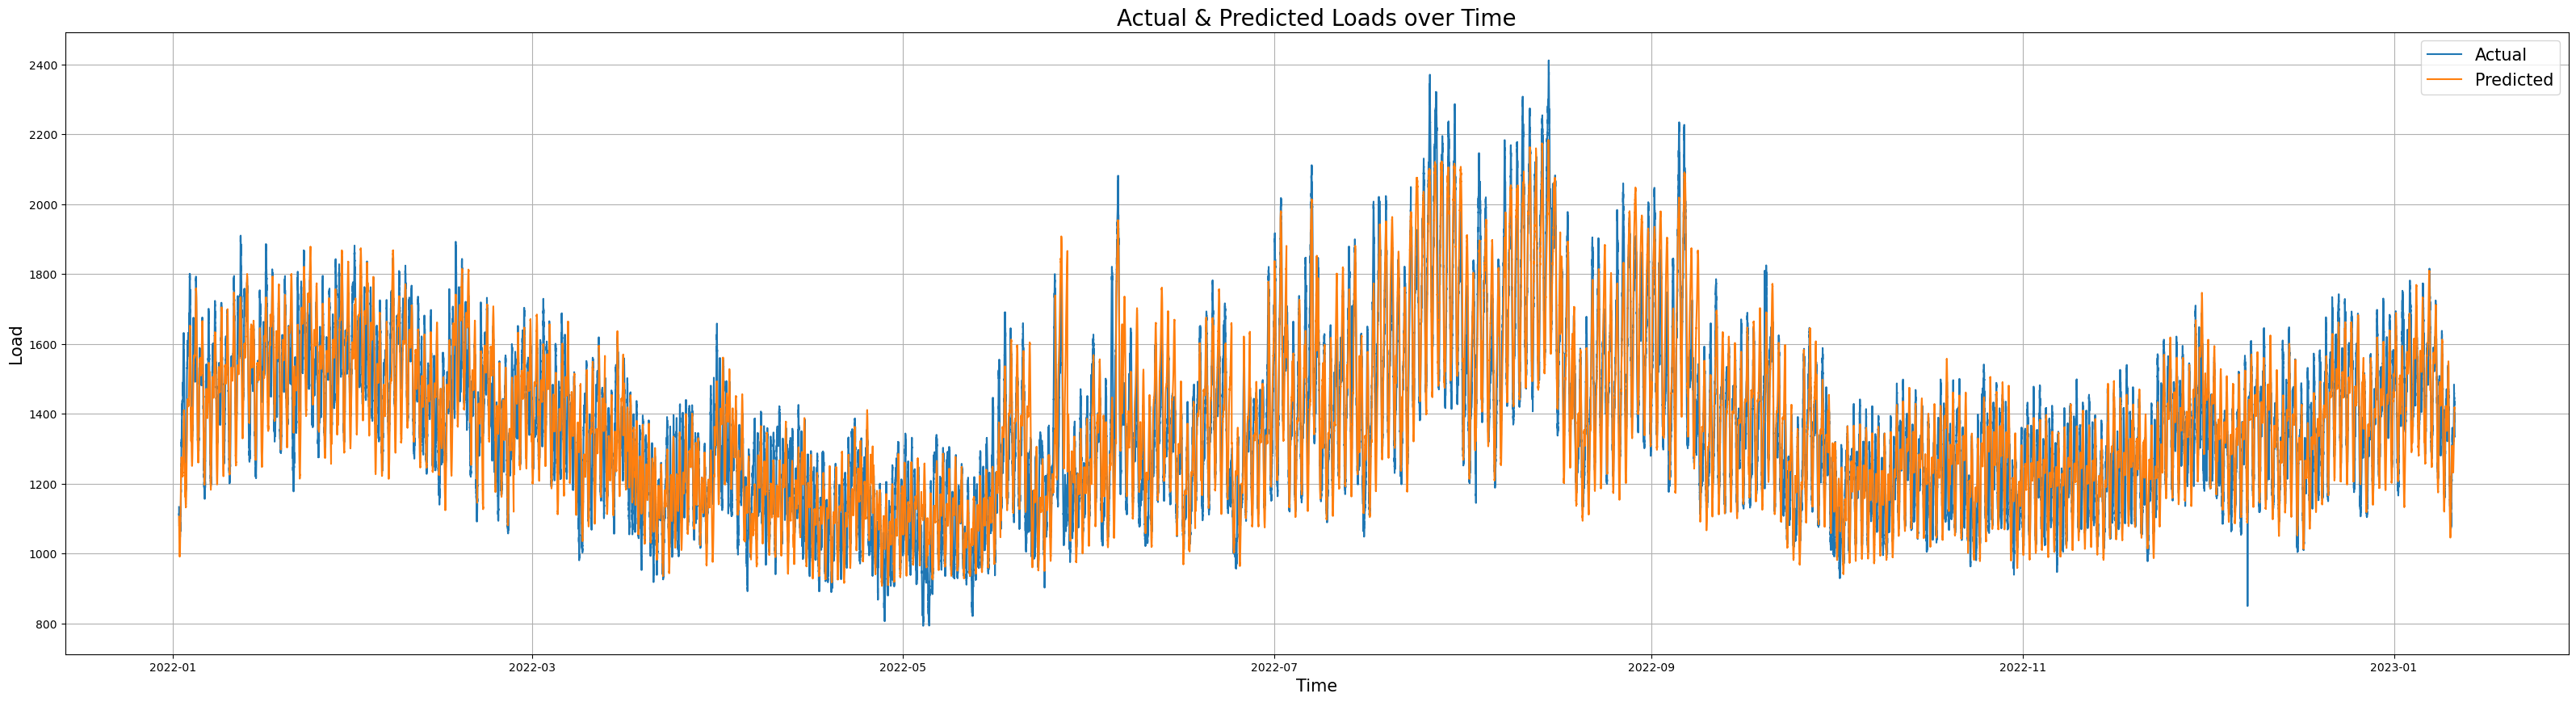

In [ ]:
# rnn_scores = evaluate_metrics(actual, predictions_rnn)
# print(f'RNN: MAE {rnn_scores[0]}, MAPE {rnn_scores[1]}, R^2 {rnn_scores[2]}')
# lstm_scores = evaluate_metrics(actual, predictions_lstm)
# print(f'LSTM: MAE {lstm_scores[0]}, MAPE {lstm_scores[1]}, R^2 {lstm_scores[2]}')
# gru_scores = evaluate_metrics(actual, predictions_gru)
# print(f'GRU: MAE {gru_scores[0]}, MAPE {gru_scores[1]}, R^2 {gru_scores[2]}')
scores = evaluate_metrics(actual, predictions)
print(f'{year} Prediction: MAE {scores[0]}, MAPE {scores[1]}, R^2 {scores[2]}')
nyiso_score = evaluate_metrics(with_forecast['load'], with_forecast['forcast'])
print(f'NYISO Forecast: MAE {nyiso_score[0]}, MAPE {nyiso_score[1]}, R^2 {nyiso_score[2]}')

time_interval = pd.date_range(start=f"{year}-01-02", periods=len(actual), freq='5min')
plt.figure(figsize=(40,10))
plt.plot(time_interval, actual, label='Actual')
# plt.plot(time_interval, predictions_rnn, label='Predicted (RNN)')
# plt.plot(time_interval, predictions_lstm, label='Predicted (LSTM)')
# plt.plot(time_interval, predictions_gru, label='Predicted (GRU)')
plt.plot(time_interval, predictions, label='Predicted')
plt.legend(fontsize=15)
plt.grid(True)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Load', fontsize=15)
plt.title('Actual & Predicted Loads over Time', fontsize=20)
plt.savefig('best_model.png')
plt.show()

In [ ]:
df_val_raw = pd.read_csv(f'./data/Prepared data/2022_features.csv')
df_val_new = df_val_raw[['timestamp', 'load', 'temp', 'year', 'month', 'day', 'hour', 'minute']].copy()
preprocessing = Preprocessor()
df_val_new = preprocessing.fit(df_val_new)
preprocessing.load_mean = preprocessor.load_mean
preprocessing.load_std = preprocessor.load_std
preprocessing.temp_mean = preprocessor.temp_mean
preprocessing.temp_std = preprocessor.temp_std
df_val_new = preprocessing.transform(df_val_new)
df_val_new = df_val_new.drop('timestamp', axis=1)
# np.save('test_data.npy', df_val.to_numpy())
# del df_val